### Import the required packages

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

I will start by only using a subset of the data Jan and Feb once the intial modeling and testing is done we can scale to the entire dataset I have a doc with the steps labed out in our shared google docs and will follow those steps here for the cleaning process

I am starting with a simple cleaning to understand what the data for just thoes two months look at

** For now keep the graphs made for both inital and cleaned may delete later** 

Current working directory: c:\diksha\Summer Sem\DataAnalysis\Notebooks
Initial Shape: (5980122, 19)
Columns:
 Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')
First Few Rows:
    VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         2  01/01/2023 12:00:00 AM  01/01/2023 12:08:00 AM              NaN   
1         2  01/01/2023 12:00:05 AM  01/01/2023 12:26:27 AM              1.0   
2         2  01/01/2023 12:00:06 AM  01/01/2023 12:05:44 AM              1.0   
3         2  01/01/2023 12:00:08 AM  01/01/2023 12:11:24 AM              1.0   
4         2  01/01/2023 12:00:09 AM  01/01/2023 12:15:10 AM              1.0   

   trip_

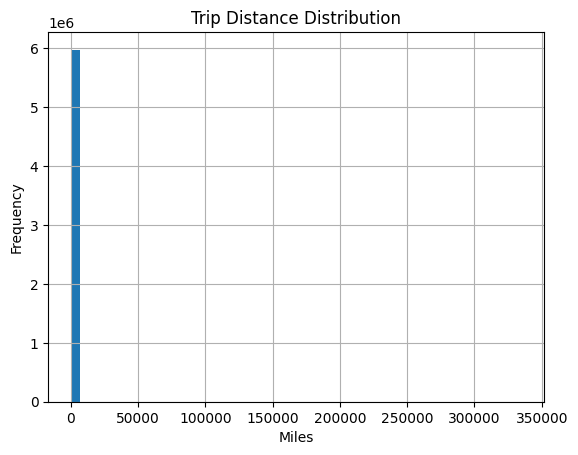

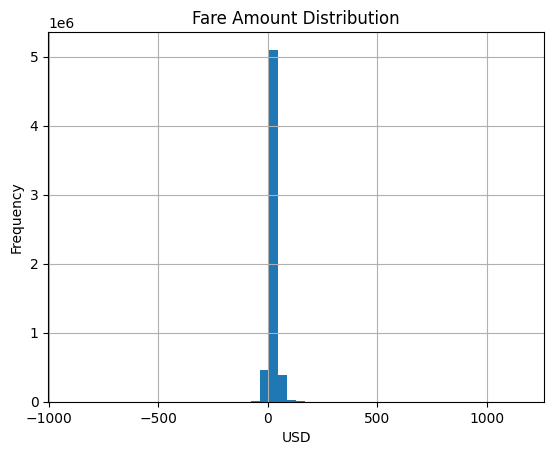

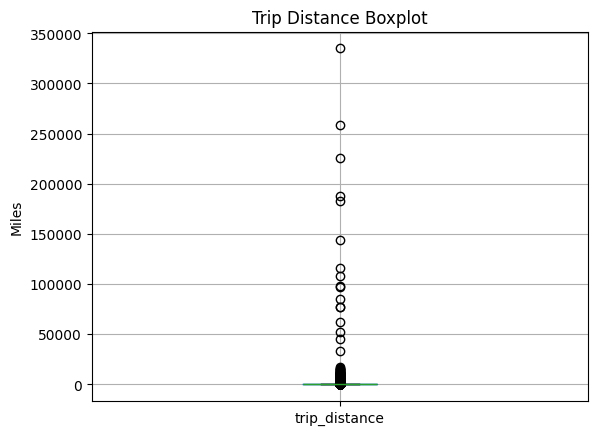

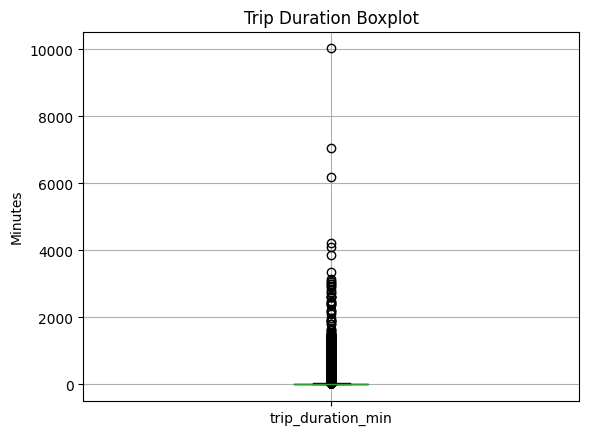


RatecodeID value counts (raw):
 RatecodeID
1.0     5535787
2.0      213274
NaN      148243
5.0       27971
99.0      26049
3.0       17716
4.0        8684
6.0          12
Name: count, dtype: int64

Payment Type value counts (raw):
 payment_type
1    4720285
2    1007839
0     148243
4      65289
3      36080
Name: count, dtype: int64


In [9]:
# 1: verify your working directory
print("Current working directory:", os.getcwd())

# Load the CSV using a relative path
df = pd.read_csv("../Data/raw_data/Jan_Feb_2023_Yellow_Taxi_Trip_Data.csv")

# Display the first few rows of the DataFrame
print("Initial Shape:", df.shape)
print("Columns:\n", df.columns)
print("First Few Rows:\n", df.head())
print("\nData Info:")
print(df.info())

#2 convert datetime columns Format: '01/01/2023 12:00:00 AM'
# Format code: '%m/%d/%Y %I:%M:%S %p'
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p',errors='coerce')

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p',errors='coerce')

# 2a Assumes timestamps were recorded in local NYC time and are currently timezone-naive

df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].dt.tz_localize(
    'America/New_York',
    ambiguous='NaT',
    nonexistent='shift_forward'
)

df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].dt.tz_localize(
    'America/New_York',
    ambiguous='NaT',
    nonexistent='shift_forward'
)

# Optional: sanity check that timestamps are now timezone-aware
print("Timezone info (pickup):", df['tpep_pickup_datetime'].dt.tz)

# 3 Compute trip duration (in minutes)
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Drop rows with NaT or negative durations
df = df[df['trip_duration_min'].notna()]
df = df[df['trip_duration_min'] > 0]

#4 Quick checks
print("\nMissing Values Summary:\n", df.isna().sum())
print("\nBasic Stats:\n", df.describe())

# Check datetime and duration validity
print("\nTrip Duration Summary:\n", df['trip_duration_min'].describe())

# Sample negative/zero fares (before cleaning)
print("\nNegative or Zero Fare Examples:\n", df[df['fare_amount'] <= 0].head())

#5 simple visuals 
# Histogram: Trip Distance
plt.figure()
df['trip_distance'].hist(bins=50)
plt.title("Trip Distance Distribution")
plt.xlabel("Miles")
plt.ylabel("Frequency")
plt.show()

# Histogram: Fare Amount
plt.figure()
df['fare_amount'].hist(bins=50)
plt.title("Fare Amount Distribution")
plt.xlabel("USD")
plt.ylabel("Frequency")
plt.show()

# Boxplot: Trip Distance (to visualize outliers)
plt.figure()
df.boxplot(column='trip_distance')
plt.title("Trip Distance Boxplot")
plt.ylabel("Miles")
plt.show()

# Boxplot: Trip Duration
plt.figure()
df.boxplot(column='trip_duration_min')
plt.title("Trip Duration Boxplot")
plt.ylabel("Minutes")
plt.show()

#breakdown of the cateqgorical 
print("\nRatecodeID value counts (raw):\n", df['RatecodeID'].value_counts(dropna=False))
print("\nPayment Type value counts (raw):\n", df['payment_type'].value_counts(dropna=False))

In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_min
0,2,2023-01-01 00:00:00-05:00,2023-01-01 00:08:00-05:00,NaN,1.53,NaN,NaN,42,41,0,12.98,0.0,0.5,0.00,0.0,1.0,14.48,NaN,NaN,8.000000
1,2,2023-01-01 00:00:05-05:00,2023-01-01 00:26:27-05:00,1.0,1.32,1.0,N,249,186,2,21.90,1.0,0.5,0.00,0.0,1.0,26.90,2.5,0.0,26.366667
2,2,2023-01-01 00:00:06-05:00,2023-01-01 00:05:44-05:00,1.0,1.70,1.0,N,125,68,2,9.30,1.0,0.5,0.00,0.0,1.0,14.30,2.5,0.0,5.633333
3,2,2023-01-01 00:00:08-05:00,2023-01-01 00:11:24-05:00,1.0,3.10,1.0,N,42,244,2,16.30,1.0,0.5,0.00,0.0,1.0,18.80,0.0,0.0,11.266667
4,2,2023-01-01 00:00:09-05:00,2023-01-01 00:15:10-05:00,1.0,3.80,1.0,N,79,231,1,19.80,1.0,0.5,7.44,0.0,1.0,32.24,2.5,0.0,15.016667


In [11]:
df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].dt.tz_localize(None)
df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].dt.tz_localize(None)

## 2. Most common pickup zones

Shows popular pickup spots like airports, train stations, etc
also helps to show if the zone mapping merge was sucessfull
can also show zones for further analysis (surge pricing, peak hours)

Further cleaing based off what I observed from the results above

Cleaned dataset saved to: c:\diksha\Summer Sem\DataAnalysis\Data\cleaned\cleaned_jan_feb_2023_taxi_data.csv
Final shape: (5706297, 29)


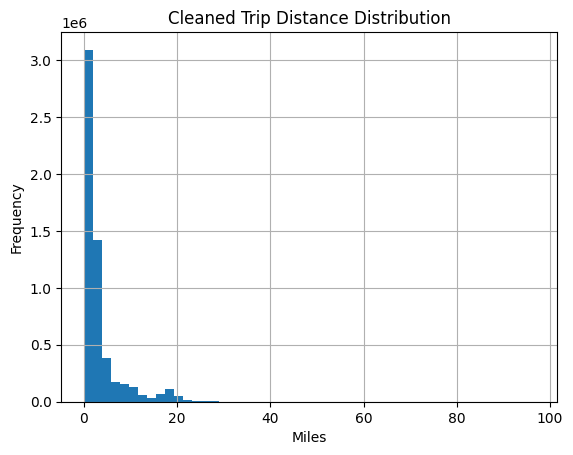

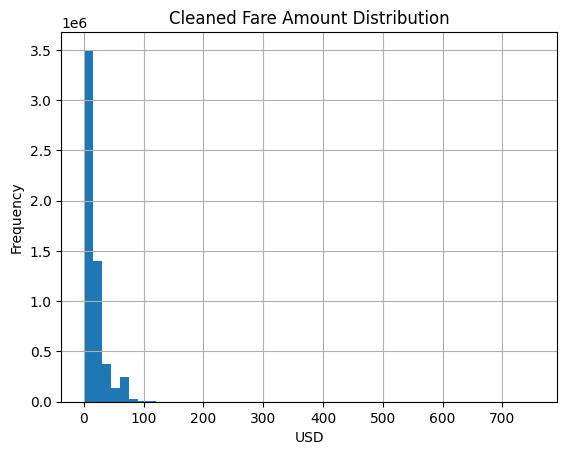

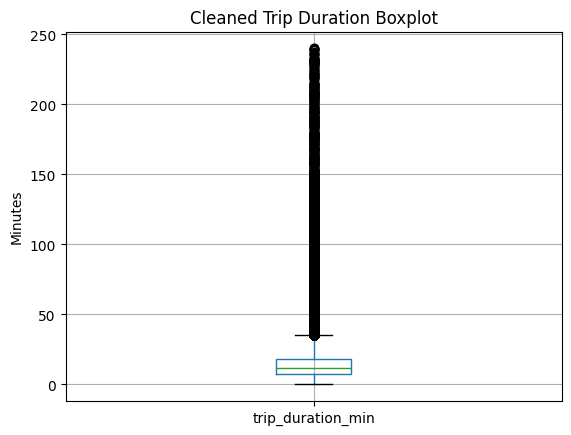

In [12]:
# gonna filter outliers here 

df = df[df['trip_distance'] < 100]            # Max 100 miles
df = df[df['trip_duration_min'] < 240]        # Max 4 hours
df = df[df['fare_amount'] > 0]                # Remove negative or zero fares
df = df[df['trip_distance'] > 0]              # Remove zero or negative distances

# handle missing values presented
# Drop rows missing critical trip data
df = df.dropna(subset=['passenger_count', 'RatecodeID', 'store_and_fwd_flag'])

# Fill optional financial fields with 0 if missing
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)
df['airport_fee'] = df['airport_fee'].fillna(0)


# add pickup date and time features 
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek  # 0 = Monday

#map categorocal values to more readable formats
ratecode_map = {
    1: "Standard",
    2: "JFK",
    3: "Newark",
    4: "Nassau/Westchester",
    5: "Negotiated",
    6: "Group Ride",
    99: "Unknown"
}
df['RatecodeID'] = df['RatecodeID'].map(ratecode_map)

payment_map = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    0: "Unknown"
}
df['payment_type'] = df['payment_type'].map(payment_map)

df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

#merge zone lookup data (pickup and dropoff zones)
zones = pd.read_csv("../Data/raw_data/taxi_zone_lookup.csv", keep_default_na=True, delimiter=',', skipinitialspace=True)
zone_lookup = zones.copy()

# Merge pickup location info
df = df.merge(
    zone_lookup.rename(columns={
        "LocationID": "PULocationID",
        "Zone": "pickup_zone",
        "Borough": "pickup_borough",
        "service_zone": "pickup_service_zone"
    }),
    on="PULocationID", how="left"
)

# Merge dropoff location info
df = df.merge(
    zone_lookup.rename(columns={
        "LocationID": "DOLocationID",
        "Zone": "dropoff_zone",
        "Borough": "dropoff_borough",
        "service_zone": "dropoff_service_zone"
    }),
    on="DOLocationID", how="left"
)


# Get the current notebook's working directory
notebook_dir = os.getcwd()  # This is the folder from where Jupyter launched the notebook
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Go to dataAnalysis/

# Now build the correct cleaned data path
output_dir = os.path.join(project_root, "Data", "cleaned")
output_file = os.path.join(output_dir, "cleaned_jan_feb_2023_taxi_data.csv")

# Make sure directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the file
df.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to: {output_file}")
print("Final shape:", df.shape)


#replotting to visualize the cleaned data
plt.figure()
df['trip_distance'].hist(bins=50)
plt.title("Cleaned Trip Distance Distribution")
plt.xlabel("Miles")
plt.ylabel("Frequency")
plt.show()

plt.figure()
df['fare_amount'].hist(bins=50)
plt.title("Cleaned Fare Amount Distribution")
plt.xlabel("USD")
plt.ylabel("Frequency")
plt.show()

plt.figure()
df.boxplot(column='trip_duration_min')
plt.title("Cleaned Trip Duration Boxplot")
plt.ylabel("Minutes")
plt.show()

In [13]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,trip_duration_min,pickup_date,pickup_hour,pickup_day_of_week,pickup_borough,pickup_zone,pickup_service_zone,dropoff_borough,dropoff_zone,dropoff_service_zone
0,2,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,Standard,0,249,186,Cash,...,26.366667,2023-01-01,0,6,Manhattan,West Village,Yellow Zone,Manhattan,Penn Station/Madison Sq West,Yellow Zone
1,2,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,Standard,0,125,68,Cash,...,5.633333,2023-01-01,0,6,Manhattan,Hudson Sq,Yellow Zone,Manhattan,East Chelsea,Yellow Zone
2,2,2023-01-01 00:00:08,2023-01-01 00:11:24,1.0,3.10,Standard,0,42,244,Cash,...,11.266667,2023-01-01,0,6,Manhattan,Central Harlem North,Boro Zone,Manhattan,Washington Heights South,Boro Zone
3,2,2023-01-01 00:00:09,2023-01-01 00:15:10,1.0,3.80,Standard,0,79,231,Credit Card,...,15.016667,2023-01-01,0,6,Manhattan,East Village,Yellow Zone,Manhattan,TriBeCa/Civic Center,Yellow Zone
4,2,2023-01-01 00:00:13,2023-01-01 00:12:52,1.0,8.97,Standard,0,132,7,Credit Card,...,12.650000,2023-01-01,0,6,Queens,JFK Airport,Airports,Queens,Astoria,Boro Zone


## Final Data Cleaning

Based on what we discussed on June 9th and Ellie's feature enhancement which I moved to this block of code for ease of readability. This should be the final time we touch the dataset.

In [15]:
df = pd.read_csv("../data/cleaned/cleaned_jan_feb_2023_taxi_data.csv", low_memory=False)

# Derived feature for fare per minute (target variable)
df['fare_per_minute'] = df['fare_amount'] / df['trip_duration_min']
# Filter out extreme fare per minute values
# This removes any fare_per_minute that is zero or above the 99th percentile
df = df[(df['fare_per_minute'] > 0) & (df['fare_per_minute'] < df['fare_per_minute'].quantile(0.99))]

# Derived feature for trip speed
df['trip_speed'] = df['trip_distance'] / df['trip_duration_min']  # miles per minute
df['trip_speed_mph'] = df['trip_speed'] * 60
df = df[(df['trip_speed_mph'] > 1) & (df['trip_speed_mph'] < 60)] # reasonable speed limits

# Deriving feature for time of day based on segmenting
def time_of_day(hour):
    if 0 <= hour < 5:
        return 'Early Morning'
    elif 5 <= hour < 10:
        return 'Morning Rush'
    elif 10 <= hour < 15:
        return 'Midday'
    elif 15 <= hour < 19:
        return 'Evening Rush'
    else:
        return 'Night'
df['time_of_day'] = df['pickup_hour'].apply(time_of_day)

# Drop columns that are not needed for analysis or modeling
# These columns are either redundant, not useful for analysis, or derived from others
columns_to_drop = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'passenger_count',
    'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'airport_fee',
    'total_amount',  # derived field
    'PULocationID', 'DOLocationID'  # drop since we now have zone/borough
]
df = df.drop(columns=columns_to_drop)

#Add Day Type (Weekday vs Weekend) weekend flag
df['is_weekend'] = df['pickup_day_of_week'].isin([5, 6])  # Saturday = 5, Sunday = 6

# Save the final cleaned dataset with derived features
final_path = os.path.join(output_dir, "final_cleaned_jan_feb_2023_taxi_data.csv")
df.to_csv(final_path, index=False)

print(f"Saved to: {final_path}")

Saved to: c:\diksha\Summer Sem\DataAnalysis\Data\cleaned\final_cleaned_jan_feb_2023_taxi_data.csv


In [16]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,trip_duration_min,pickup_date,pickup_hour,pickup_day_of_week,pickup_borough,pickup_zone,pickup_service_zone,dropoff_borough,dropoff_zone,dropoff_service_zone,fare_per_minute,trip_speed,trip_speed_mph,time_of_day,is_weekend
0,2023-01-01 00:00:05,2023-01-01 00:26:27,1.32,21.9,26.366667,2023-01-01,0,6,Manhattan,West Village,Yellow Zone,Manhattan,Penn Station/Madison Sq West,Yellow Zone,0.830594,0.050063,3.003793,Early Morning,True
1,2023-01-01 00:00:06,2023-01-01 00:05:44,1.70,9.3,5.633333,2023-01-01,0,6,Manhattan,Hudson Sq,Yellow Zone,Manhattan,East Chelsea,Yellow Zone,1.650888,0.301775,18.106509,Early Morning,True
2,2023-01-01 00:00:08,2023-01-01 00:11:24,3.10,16.3,11.266667,2023-01-01,0,6,Manhattan,Central Harlem North,Boro Zone,Manhattan,Washington Heights South,Boro Zone,1.446746,0.275148,16.508876,Early Morning,True
3,2023-01-01 00:00:09,2023-01-01 00:15:10,3.80,19.8,15.016667,2023-01-01,0,6,Manhattan,East Village,Yellow Zone,Manhattan,TriBeCa/Civic Center,Yellow Zone,1.318535,0.253052,15.183130,Early Morning,True
4,2023-01-01 00:00:13,2023-01-01 00:12:52,8.97,34.5,12.650000,2023-01-01,0,6,Queens,JFK Airport,Airports,Queens,Astoria,Boro Zone,2.727273,0.709091,42.545455,Early Morning,True


## Converting line by line code into Functions

This will be used later down the line when we are scaling the model to the entire year we can just use the functions rather than retyping all the code plus this also has all the code into one code block for cleaning. Will have to do the same for when we train/test the data

In [ ]:
def clean_and_engineer(df, zone_lookup):
    # 1. Parse datetime
    df['tpep_pickup_datetime'] = pd.to_datetime(
        df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce'
    )
    df['tpep_dropoff_datetime'] = pd.to_datetime(
        df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce'
    )

    df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='shift_forward')
    df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='shift_forward')

    # 2. Trip duration (minutes)
    df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    df = df[df['trip_duration_min'].notna() & (df['trip_duration_min'] > 0)]

    # 3. Basic filters
    df = df[df['trip_distance'] > 0]
    df = df[df['trip_distance'] < 100]
    df = df[df['trip_duration_min'] < 240]
    df = df[df['fare_amount'] > 0]

    # 4. Drop rows missing required categorical values
    df = df.dropna(subset=['passenger_count', 'RatecodeID', 'store_and_fwd_flag'])

    # 5. Fill financial fields with 0
    for col in ['congestion_surcharge', 'airport_fee']:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # 6. Extract time-based features
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['is_weekend'] = df['pickup_day_of_week'].isin([5, 6])

    # 7. Categoricals mapping
    df['RatecodeID'] = df['RatecodeID'].map({
        1: "Standard", 2: "JFK", 3: "Newark", 4: "Nassau/Westchester",
        5: "Negotiated", 6: "Group Ride", 99: "Unknown"
    })
    df['payment_type'] = df['payment_type'].map({
        1: "Credit Card", 2: "Cash", 3: "No Charge", 4: "Dispute", 0: "Unknown"
    })
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

    # 8. Merge zone metadata
    df = df.merge(
        zone_lookup.rename(columns={
            "LocationID": "PULocationID",
            "Zone": "pickup_zone", "Borough": "pickup_borough", "service_zone": "pickup_service_zone"
        }),
        on="PULocationID", how="left"
    )

    df = df.merge(
        zone_lookup.rename(columns={
            "LocationID": "DOLocationID",
            "Zone": "dropoff_zone", "Borough": "dropoff_borough", "service_zone": "dropoff_service_zone"
        }),
        on="DOLocationID", how="left"
    )

    # 9. Derived variables
    df['fare_per_minute'] = df['fare_amount'] / df['trip_duration_min']
    df = df[(df['fare_per_minute'] > 0) & (df['fare_per_minute'] < df['fare_per_minute'].quantile(0.99))]

    df['trip_speed'] = df['trip_distance'] / df['trip_duration_min']
    df['trip_speed_mph'] = df['trip_speed'] * 60
    df = df[(df['trip_speed_mph'] > 1) & (df['trip_speed_mph'] < 60)]

    def time_of_day(hour):
        if 0 <= hour < 5:
            return 'Early Morning'
        elif 5 <= hour < 10:
            return 'Morning Rush'
        elif 10 <= hour < 15:
            return 'Midday'
        elif 15 <= hour < 19:
            return 'Evening Rush'
        else:
            return 'Night'

    df['time_of_day'] = df['pickup_hour'].apply(time_of_day)

    # 10. Drop unused columns
    drop_cols = [
        'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'passenger_count',
        'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
        'improvement_surcharge', 'congestion_surcharge', 'airport_fee',
        'total_amount', 'PULocationID', 'DOLocationID'
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    return df

## How to use it later (full datasets in chunks)

 Load zone lookup table once
zone_lookup = pd.read_csv("../Data/raw_data/taxi_zone_lookup.csv", skipinitialspace=True)

 Clean Jan–Feb subset
df_subset = pd.read_csv("../Data/raw_data/Jan_Feb_2023_Yellow_Taxi_Trip_Data.csv")
df_cleaned = clean_and_engineer(df_subset, zone_lookup)


## How to Scale to Full dataset

full_path = "../Data/raw_data/2023_Yellow_Taxi.csv"
chunks = pd.read_csv(full_path, chunksize=500_000)

cleaned_chunks = [clean_and_engineer(chunk, zone_lookup) for chunk in chunks]
df_full_cleaned = pd.concat(cleaned_chunks, ignore_index=True)

df_full_cleaned.to_csv("../Data/cleaned/final_cleaned_all_2023.csv", index=False)

## Light Data Exploration

Based on the basic cleaning I have done so far I want to look into low-risk analysis that can run parallel with the rest of the possible cleanings left to do 

## 1. trip_duration vs pickup_hour

trip_duration_min vs pickup_hour:  This could help us see if travel time varies by time of day can help detect rush hour patterns

can be useful for demand forecasting and anomaly detection (it can be considered unsually long durations at odd hours could lead to data wuality issues or special events occuring)

this could be used as a baseline for modeling demand or pricing

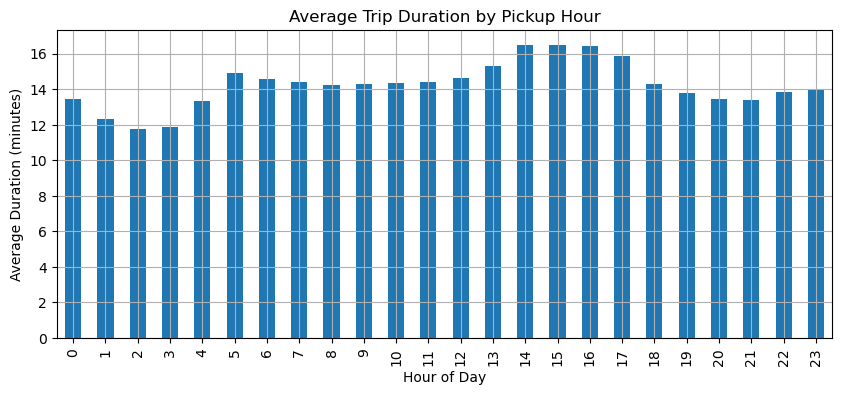

In [ ]:
# Average trip duration by pickup hour
avg_duration_by_hour = df.groupby('pickup_hour')['trip_duration_min'].mean()

avg_duration_by_hour.plot(kind='bar', figsize=(10, 4), title='Average Trip Duration by Pickup Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Duration (minutes)')
plt.grid(True)
plt.show()


discussion: Peak durations in the afternoon 2-4pm shows the highest avg trip duration (16-17mins) 

could mean--> afternoon congestion due to school dismissal, early commutes
more long-distance rides in that window (airport pickups)
Could also be pre-rush hour delays

Shorter trips in the early morning and night
12am-5am avg lower (12-14mins) there seems to be a dip around 2-3am could mean --> lower traffic volumes, shorter trips, fewer overall trips (may skew durations slighty)

Moderate and stable midday hours: 
8am-1pm ride durations are stable (14-15mins) --> moderate congestion, balanced trip lengths

Possible Feature Engineering  -->       We could use pickup_hour as a feature in models for: fare prediciton, trip duration, demand clustering

## 1(a). trip volume by hour
following this I want to further investigate trip volume by hour of day to show how busy each hour is - could be useful for comparing demand to trip duration

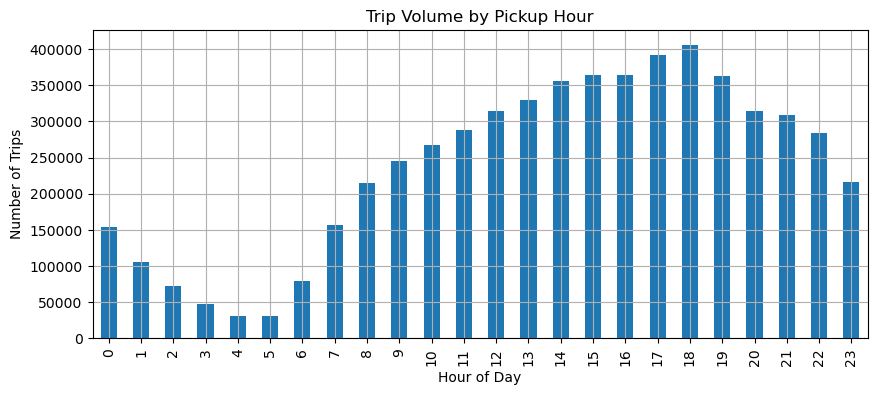

In [ ]:
# Count trips per pickup hour
trip_volume_by_hour = df['pickup_hour'].value_counts().sort_index()

# Plot
trip_volume_by_hour.plot(kind='bar', figsize=(10, 4), title='Trip Volume by Pickup Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()


Discussion: 

peak demand hours: 3-7pm peak at 5-6pm with over 400,00 trips per hour (consistant with classic evening commute and after-work activity)

morning build-up from 7am onwards there is a clear ramp up in activity (suggests morning commute traffic and early-day travel - possibly slower due to congestion )

very low volume at night: 2am-5am trip volume drops - possibly due to fewer rides, reduced taxi supply, end of nightlife

Operational efficiency	      -->           Helps identify off-peak hours when you could clean, recharge, or reposition vehicles.
Feature engineering	          -->           Pickup hour should be a strong feature in any demand, duration, or fare prediction model.

## 1(b). avg trip duration by hour and weekday

can show how duration patterns change between weekdays and weekends - shows how congestion and behaviors shifts on weekends

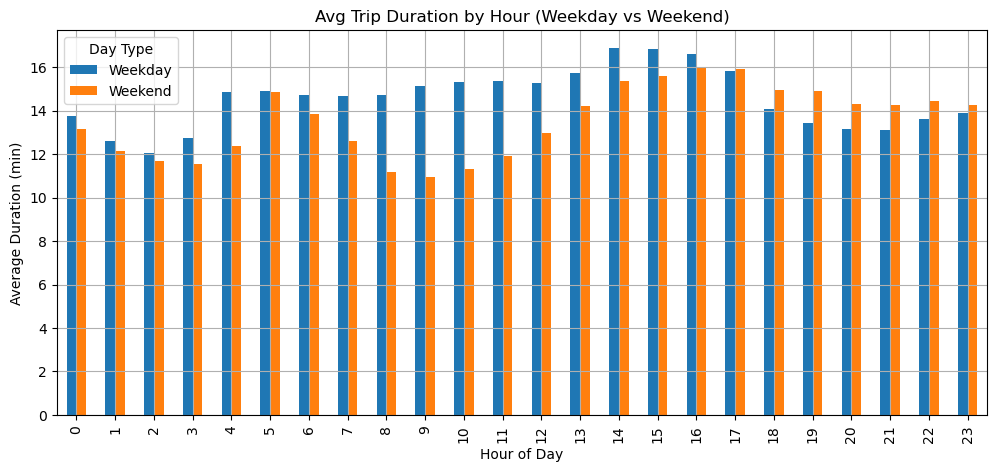

In [ ]:
# Create weekday/weekend label
df['day_type'] = df['pickup_day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by pickup hour and day_type
avg_duration_daytype = df.groupby(['pickup_hour', 'day_type'])['trip_duration_min'].mean().unstack()

# Plot
avg_duration_daytype.plot(kind='bar', figsize=(12, 5), title='Avg Trip Duration by Hour (Weekday vs Weekend)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Duration (min)')
plt.grid(True)
plt.legend(title='Day Type')
plt.show()


Discussion: 
Weekdays have longer trips during business hours: peak from 1-4pm, with avg trip times reaching 17 plus mins

weekend trips are shorter and stable, they are 1-2 mins shorter on avg and seems to be more consistant throughout the day

early mornings for both weekday/end are the same from 12am-6am

Congestion awareness	        -->                  Weekday traffic patterns lead to longer trips — may inform pricing or routing.
User segmentation	            -->                  Weekday riders may have different needs (longer, time-sensitive trips).
Feature engineering	            -->                  Add a day_type flag to your dataset for models — it’s clearly predictive.
Marketing / Ops                 -->                	 Weekends could be ideal for promotions or testing changes due to steadier patterns.

## 1(c). Trip volume by pickup Borough
this will show which boroughs via the zone merge have the most pickups (id spatial demand- useful for targeting zones and planning service)

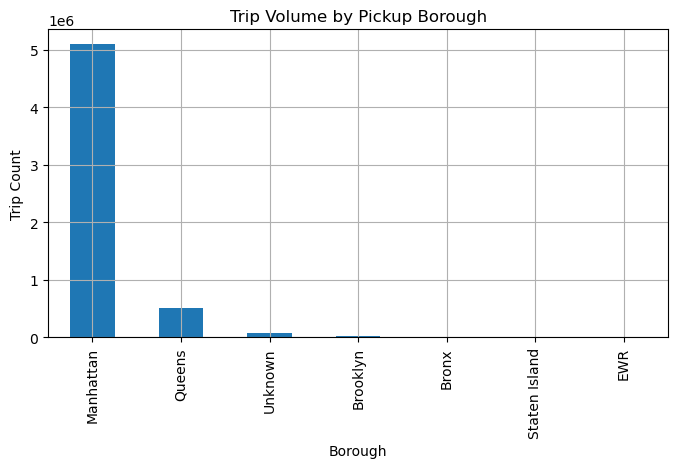

In [ ]:
# Requires 'pickup_borough' from the zone lookup merge
pickup_borough_counts = df['pickup_borough'].value_counts()

# Plot
pickup_borough_counts.plot(kind='bar', figsize=(8, 4), title='Trip Volume by Pickup Borough')
plt.xlabel('Borough')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()

Discussion: Manhattan dominates taxi activity (over 5 million trips )
confirms that Manhattan is the transportation hub and dense with tourist travelers, and commuters

Queens comes second (most liekly due to the airport JFK and LaGuardia)

Boroughs like Brooklyn, Bronx, and Staten Island have very few pickups. due to -->
Residents rely more on other transit (subway, rideshare)

Taxis are not as available or not a preferred mode

“Unknown” Borough
A small but visible slice is marked as Unknown.

Likely due to:

Missing or invalid PULocationIDs

Taxi zone data not matching location codes will need further investigation

Operational decisions	       -->              Focus efforts (fleet, promotions) on Manhattan and major Queens zones
Modeling	                   -->              Include pickup borough as a categorical feature — it's clearly informative
Anomaly detection	           -->              Trips from boroughs with very few pickups (e.g. Staten Island) may need validation
Strategic expansion	           -->              If expanding service or pricing zones, this shows where the real volume is


## (2). Top ten pickup zones

Helpful to shpw popular pick up spots and lets us validate if the zone mapping merege was sucessful and helps target zones for futher anaylsis for example peak hours

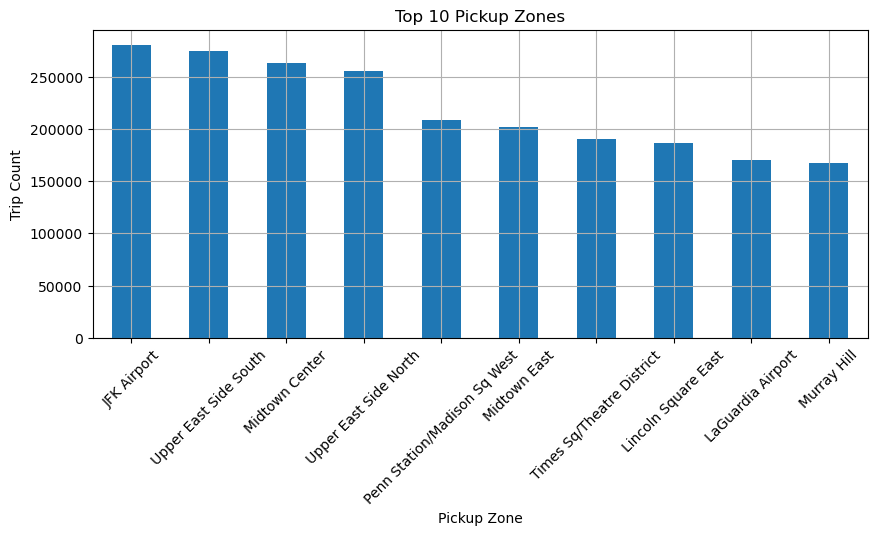

In [ ]:
# Requires zone names to be merged already which have been done above
top_pickups = df['pickup_zone'].value_counts().head(10)

top_pickups.plot(kind='bar', figsize=(10, 4), title='Top 10 Pickup Zones')
plt.xlabel('Pickup Zone')
plt.ylabel('Trip Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Discussion: 

JFK is number one in pick up location suggesting that there is a high reliance on taxis for airport transit

Manhattan once again dominates the other fields nearly all of the other top zones: upper east side south and north, midtown center and midtown east, penn station, times sqaure, Licoln sqaure --> these are all hugh density resident commerical areas, major transit hubs and tourist attractions, these are likely associated with peak hours and commuter behavior


Use Case	                                                             
Operations & Dispatch	            -->                Focus drivers/fleet in these high-traffic zones to increase efficiency
Surge Pricing / Revenue             -->         	These zones likely yield most revenue, so optimizing rates here matters
Geospatial Modeling	                -->                Use pickup zone as a predictive feature in fare/duration models
Marketing & Policy	                -->                 If we plan promotions or driver incentives, these are ideal starting points

## (2a). Top pickup dropoff route pairs (most common trip routes)  

This will show the most frequent combinations of pickup and dropoff zones

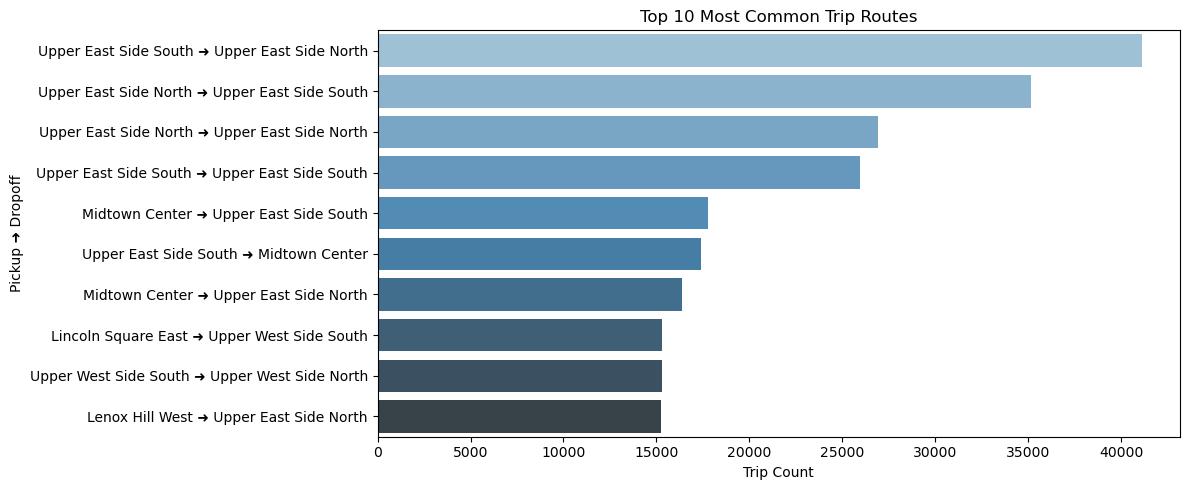

In [ ]:
# Count the top 10 most common pickup-dropoff zone pairs
top_routes = (
    df.groupby(['pickup_zone', 'dropoff_zone'])
    .size()
    .reset_index(name='trip_count')
    .sort_values(by='trip_count', ascending=False)
    .head(10)
)

# Bar chart of top routes
top_routes['route'] = top_routes['pickup_zone'] + " ➜ " + top_routes['dropoff_zone']

plt.figure(figsize=(12, 5))
sns.barplot(data=top_routes, y='route', x='trip_count', hue='route', palette='Blues_d', legend=False)
plt.title('Top 10 Most Common Trip Routes')
plt.xlabel('Trip Count')
plt.ylabel('Pickup ➜ Dropoff')
plt.tight_layout()
plt.show()


Discussion: 
Short haul neighborhood trips are the largest for this dataset with the common routes occuring intra-Manhattan: these are short dense, high-turnover rides that can reflect possibly daily routines (schools, errands, local work commutes), and frequent low distance taxi usage buy locals or short-range travelers

High urban density = high trip frequency --- this shows that no outer borough or sirport made the top ten, implies that majority of taci traffic is local

Demand modeling	"Pickup zone + dropoff zone" is a powerful compound feature — clearly highly predictive

## (2b). Avg fare by pickup zone


This can give us insight into which pickup zones tend to generate higher fares on avg - possibly indicating long distance or high traffic areas

where taxi rides are most valuable, not just most common.

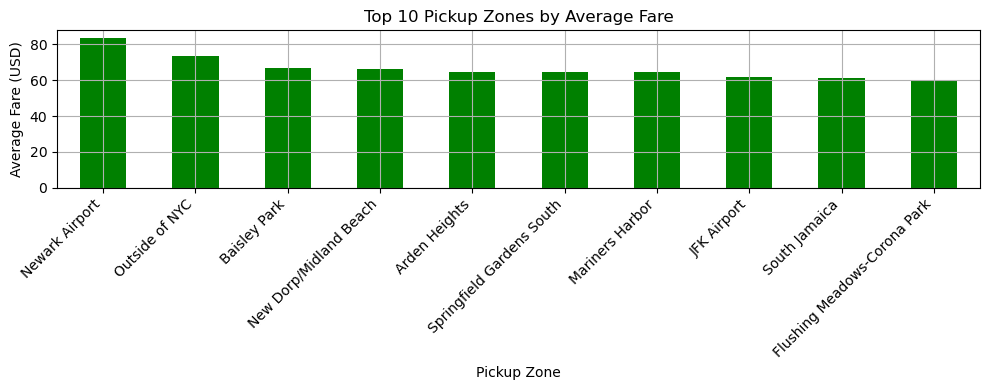

In [ ]:
# Group by pickup zone and calculate average fare
avg_fare_by_zone = (
    df.groupby('pickup_zone')['fare_amount']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

avg_fare_by_zone.plot(kind='bar', figsize=(10, 4), title='Top 10 Pickup Zones by Average Fare', color='green')
plt.ylabel('Average Fare (USD)')
plt.xlabel('Pickup Zone')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Discussion: Airport and edge zones domiate the high fare - makes sense becasue they are far from Manhattan, would trigger flat or high base rates, probably involves tolls, surcharges, and tips. 

even though the trip counts are low for zones like arden heights, springfield, midland beach the fares are high due to long distance into central boroughs.

What is intersting is that high voume zones like midtwon, upper east side do not appear here in contrast to the graph above meaning: the trips are more common but are usually shorter and have a lower fare

Modeling features  --->	We could use average fare by zone as a target encoding in fare prediction models

## 3. Passenger count distrubiution

ids invalid values 


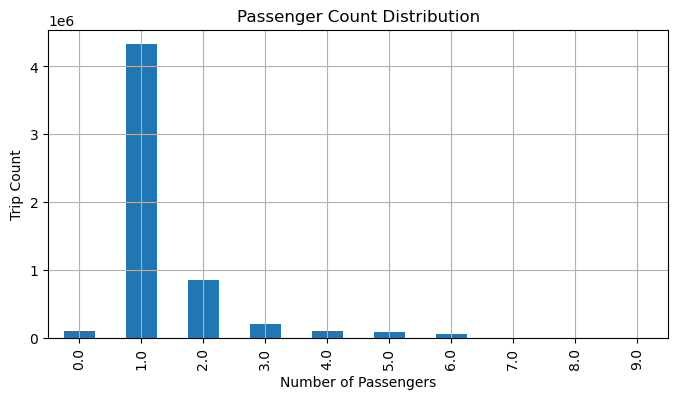

In [ ]:
df['passenger_count'].value_counts().sort_index().plot(kind='bar', figsize=(8, 4))
plt.title('Passenger Count Distribution')
plt.xlabel('Number of Passengers')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()


Discussion: Solo riders are very common and to be expected with over 4 million trips, 2-3 riders are resonable and implies shared rides with friends, couples, small groups. 

Red flags that can help with our data cleaning are zeros and very high counts: Passenger counts that = 0 has hundered thousand entires and are liekly missing or misrecorded values 

values of 7,8,9 are very rare: this could also be input errors, group bookings, and possibly worth filtering or capping at perhaps 5-6? 

Data cleaning	--->               Passenger count of 0 should likely be removed or imputed
Feature engineering	--->           could bucket this field (e.g., solo, pair, group) for modeling or dashboards
Model reliability  -->          	Helps ensure this variable is clean if used for fare/tip prediction

## Continuing Data Exploration

### Number of Trips Per Day

pickup_date
2023-01-01     71211
2023-01-02     62779
2023-01-03     81801
2023-01-04     91014
2023-01-05     96763
2023-01-06     98247
2023-01-07    100765
2023-01-08     81527
2023-01-09     81508
2023-01-10     95912
Name: count, dtype: int64


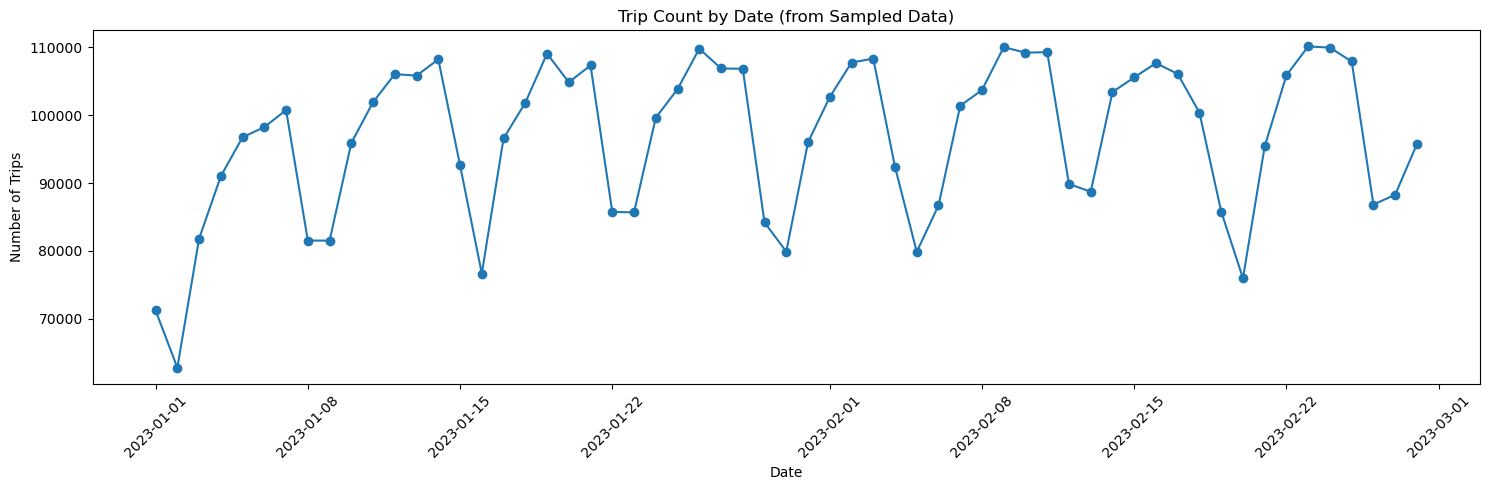

In [ ]:
# Count the number of trips per day
date_counts = df['pickup_date'].value_counts().sort_index()

# Inspect a few dates
print(date_counts.head(10))

# Plot the distribution of trip counts for dates
plt.figure(figsize=(15, 5))
plt.plot(date_counts.index, date_counts.values, marker='o')
plt.xticks(rotation=45)
plt.title("Trip Count by Date (from Sampled Data)")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

#### **Observations**
- The number of trips recorded each day appears to be cyclical - it seems like there are weekly cycles with consistent peaks and valleys
- May have to consider separate models for weekday vs. weekend patterns?
- Would be interesting to see if holidays (New Year's Day, MLK Day, Presidents Day, Valentines Day, etc.) have any impact on demand
- Would also be interesting to see if weather events (big snowstorm) have big impacts on demand, we'll try to address that after the MVP

### Trip Frequency Based on Day of Week and Time of Day

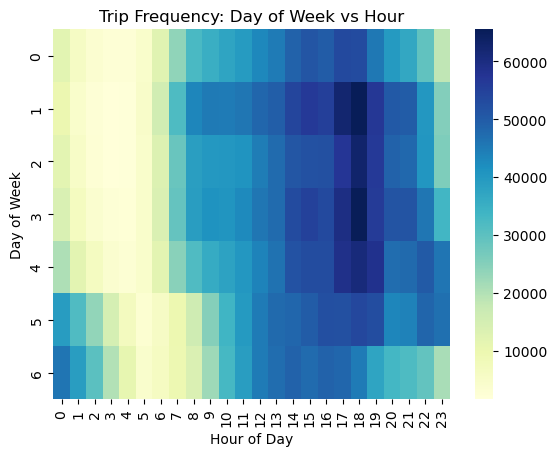

In [ ]:
heatmap_data = df.groupby(['pickup_day_of_week', 'pickup_hour']).size().unstack()
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Trip Frequency: Day of Week vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

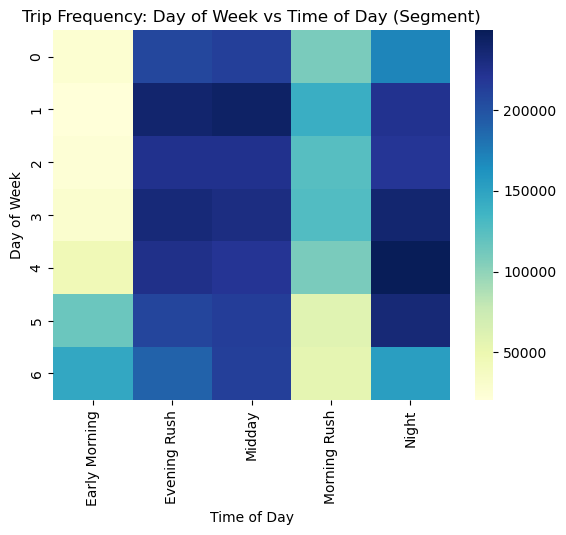

In [ ]:
heatmap_data = df.groupby(['pickup_day_of_week', 'time_of_day']).size().unstack()
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Trip Frequency: Day of Week vs Time of Day (Segment)')
plt.xlabel('Time of Day')
plt.ylabel('Day of Week')
plt.show()

### Analyzing Pickup/Dropoff Pairs

In [ ]:
pair_counts = df.groupby(['pickup_zone', 'dropoff_zone', 'time_of_day', 'day_type']).size().reset_index(name='trip_count').sort_values(by='trip_count', ascending = False)

In [ ]:
pair_counts

,pickup_zone,dropoff_zone,time_of_day,day_type,trip_count
92105,Upper East Side South,Upper East Side North,Midday,Weekday,11555
90680,Upper East Side North,Upper East Side South,Midday,Weekday,11313
92103,Upper East Side South,Upper East Side North,Evening Rush,Weekday,10202
90678,Upper East Side North,Upper East Side South,Evening Rush,Weekday,9456
92115,Upper East Side South,Upper East Side South,Midday,Weekday,8006
...,...,...,...,...,...
61545,Midtown Center,Murray Hill-Queens,Midday,Weekend,1
61547,Midtown Center,New Dorp/Midland Beach,Night,Weekday,1
7995,Central Harlem,Belmont,Midday,Weekend,1
7994,Central Harlem,Bedford Park,Night,Weekend,1


#### Circuit Flow - How many pickups happened in the same dropoff zone within 15 minutes of a trip's dropoff time?

In [ ]:
# Create relevant dataframe
circuit_df = df[['pickup_zone', 'dropoff_zone', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']]

# Create dataframe for future pickups
future_df = df[['tpep_pickup_datetime', 'pickup_zone']].copy()
future_df.rename(columns={
    'pickup_datetime': 'future_pickup_time',
    'pickup_zone': 'dropoff_zone'  # aligning with dropoff_zone for join
}, inplace=True)



In [ ]:
# Create copy of dataframe and sort by dropoff time ascending
circuit_df = df[['pickup_zone', 'dropoff_zone', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']].copy()
circuit_df = circuit_df.sort_values(by=['tpep_dropoff_datetime'], ascending=True)
circuit_df

,pickup_zone,dropoff_zone,tpep_pickup_datetime,tpep_dropoff_datetime
69,Yorkville West,Yorkville West,2023-01-01 00:03:33,2023-01-01 00:04:16
7,East Village,Gramercy,2023-01-01 00:00:47,2023-01-01 00:04:32
53,Lincoln Square East,Upper West Side South,2023-01-01 00:03:04,2023-01-01 00:05:33
1,Hudson Sq,East Chelsea,2023-01-01 00:00:06,2023-01-01 00:05:44
164,Clinton West,Clinton West,2023-01-01 00:05:38,2023-01-01 00:06:35
...,...,...,...,...
5704391,JFK Airport,Outside of NYC,2023-02-28 23:09:51,2023-03-01 00:35:42
5706263,Times Sq/Theatre District,Newark Airport,2023-02-28 23:44:13,2023-03-01 00:36:57
5705868,LaGuardia Airport,Outside of NYC,2023-02-28 23:35:16,2023-03-01 00:41:25
5706224,Outside of NYC,Outside of NYC,2023-02-28 23:43:14,2023-03-01 01:10:39


In [ ]:
# Create dataframe for 'next pickup'
next_pickup_df = df[['pickup_zone', 'tpep_pickup_datetime', 'dropoff_zone', 'tpep_dropoff_datetime']].copy()
next_pickup_df.rename(columns={'tpep_pickup_datetime': 'next_pickup_time', 'pickup_zone': 'next_pickup'}, inplace=True)
next_pickup_df.sort_values(by=['next_pickup_time'], ascending=True)

,next_pickup,next_pickup_time,dropoff_zone,tpep_dropoff_datetime
0,West Village,2023-01-01 00:00:05,Penn Station/Madison Sq West,2023-01-01 00:26:27
1,Hudson Sq,2023-01-01 00:00:06,East Chelsea,2023-01-01 00:05:44
2,Central Harlem North,2023-01-01 00:00:08,Washington Heights South,2023-01-01 00:11:24
3,East Village,2023-01-01 00:00:09,TriBeCa/Civic Center,2023-01-01 00:15:10
4,JFK Airport,2023-01-01 00:00:13,Astoria,2023-01-01 00:12:52
...,...,...,...,...
5706292,JFK Airport,2023-02-28 23:44:50,Midwood,2023-03-01 00:10:38
5706293,Penn Station/Madison Sq West,2023-02-28 23:44:53,TriBeCa/Civic Center,2023-02-28 23:53:32
5706294,Central Park,2023-02-28 23:44:56,Woodside,2023-02-28 23:48:16
5706295,Lincoln Square East,2023-02-28 23:44:58,Yorkville West,2023-02-28 23:56:15


In [ ]:
# Merge the tables
flow = pd.merge_asof(
    circuit_df.sort_values('tpep_dropoff_datetime'),  # left DataFrame
    next_pickup_df.sort_values('next_pickup_time'),  # right DataFrame
    left_on='tpep_dropoff_datetime',
    right_on='next_pickup_time',
    left_by='dropoff_zone',
    right_by='next_pickup',
    direction='forward',
    suffixes=('', '_next')
    #tolerance=pd.Timedelta('15m')  # optional, time window filter
)
flow

,pickup_zone,dropoff_zone,tpep_pickup_datetime,tpep_dropoff_datetime,next_pickup,next_pickup_time,dropoff_zone_next,tpep_dropoff_datetime_next
0,Yorkville West,Yorkville West,2023-01-01 00:03:33,2023-01-01 00:04:16,Yorkville West,2023-01-01 00:05:09,Sutton Place/Turtle Bay North,2023-01-01 00:11:20
1,East Village,Gramercy,2023-01-01 00:00:47,2023-01-01 00:04:32,Gramercy,2023-01-01 00:05:37,East Chelsea,2023-01-01 00:14:56
2,Lincoln Square East,Upper West Side South,2023-01-01 00:03:04,2023-01-01 00:05:33,Upper West Side South,2023-01-01 00:05:41,Clinton West,2023-01-01 00:21:21
3,Hudson Sq,East Chelsea,2023-01-01 00:00:06,2023-01-01 00:05:44,East Chelsea,2023-01-01 00:07:57,Manhattanville,2023-01-01 00:33:52
4,Clinton West,Clinton West,2023-01-01 00:05:38,2023-01-01 00:06:35,Clinton West,2023-01-01 00:13:59,Central Harlem,2023-01-01 00:28:31
...,...,...,...,...,...,...,...,...
5706292,JFK Airport,Outside of NYC,2023-02-28 23:09:51,2023-03-01 00:35:42,NaN,NaT,NaN,NaT
5706293,Times Sq/Theatre District,Newark Airport,2023-02-28 23:44:13,2023-03-01 00:36:57,NaN,NaT,NaN,NaT
5706294,LaGuardia Airport,Outside of NYC,2023-02-28 23:35:16,2023-03-01 00:41:25,NaN,NaT,NaN,NaT
5706295,Outside of NYC,Outside of NYC,2023-02-28 23:43:14,2023-03-01 01:10:39,NaN,NaT,NaN,NaT


In [ ]:
# add column indicating deadhead if wait for next trip > 15 mins
def deadhead(wait_time, threshold=pd.Timedelta('15m')):
    if pd.isnull(wait_time):
        return 'Deadhead'  # No next pickup matched
    return 'Circuit' if wait_time <= threshold else 'Deadhead'

# Calculate wait time between dropoff and next pickup
flow['wait_time'] = flow['next_pickup_time'] - flow['tpep_dropoff_datetime']

# Apply the function row-wise to create the flag
flow['Deadhead/Circuit'] = flow['wait_time'].apply(deadhead)

In [ ]:
flow

,pickup_zone,dropoff_zone,tpep_pickup_datetime,tpep_dropoff_datetime,next_pickup,next_pickup_time,dropoff_zone_next,tpep_dropoff_datetime_next,wait_time,Deadhead/Circuit
0,Yorkville West,Yorkville West,2023-01-01 00:03:33,2023-01-01 00:04:16,Yorkville West,2023-01-01 00:05:09,Sutton Place/Turtle Bay North,2023-01-01 00:11:20,0 days 00:00:53,Circuit
1,East Village,Gramercy,2023-01-01 00:00:47,2023-01-01 00:04:32,Gramercy,2023-01-01 00:05:37,East Chelsea,2023-01-01 00:14:56,0 days 00:01:05,Circuit
2,Lincoln Square East,Upper West Side South,2023-01-01 00:03:04,2023-01-01 00:05:33,Upper West Side South,2023-01-01 00:05:41,Clinton West,2023-01-01 00:21:21,0 days 00:00:08,Circuit
3,Hudson Sq,East Chelsea,2023-01-01 00:00:06,2023-01-01 00:05:44,East Chelsea,2023-01-01 00:07:57,Manhattanville,2023-01-01 00:33:52,0 days 00:02:13,Circuit
4,Clinton West,Clinton West,2023-01-01 00:05:38,2023-01-01 00:06:35,Clinton West,2023-01-01 00:13:59,Central Harlem,2023-01-01 00:28:31,0 days 00:07:24,Circuit
...,...,...,...,...,...,...,...,...,...,...
5706292,JFK Airport,Outside of NYC,2023-02-28 23:09:51,2023-03-01 00:35:42,NaN,NaT,NaN,NaT,NaT,Deadhead
5706293,Times Sq/Theatre District,Newark Airport,2023-02-28 23:44:13,2023-03-01 00:36:57,NaN,NaT,NaN,NaT,NaT,Deadhead
5706294,LaGuardia Airport,Outside of NYC,2023-02-28 23:35:16,2023-03-01 00:41:25,NaN,NaT,NaN,NaT,NaT,Deadhead
5706295,Outside of NYC,Outside of NYC,2023-02-28 23:43:14,2023-03-01 01:10:39,NaN,NaT,NaN,NaT,NaT,Deadhead


In [ ]:
# Count occurrences of Deadhead and Circuit per pickup_zone
counts = flow.groupby(['pickup_zone', 'Deadhead/Circuit']).size().unstack(fill_value=0)

# Calculate proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# Add a new column for total count of trips
proportions['total_trips'] = counts.sum(axis=1)

# Sort by proportion of Deadhead (or Circuit) for better visualization
proportions = proportions.sort_values(by='Deadhead', ascending=False)

proportions

Deadhead/Circuit,Circuit,Deadhead,total_trips
pickup_zone,,,
Stapleton,0.000000,1.000000,4
Westerleigh,0.000000,1.000000,2
Country Club,0.000000,1.000000,3
Freshkills Park,0.000000,1.000000,2
Broad Channel,0.000000,1.000000,3
...,...,...,...
Central Park,0.975472,0.024528,92627
Upper East Side North,0.977504,0.022496,255160
Governor's Island/Ellis Island/Liberty Island,1.000000,0.000000,1


<Figure size 1000x800 with 0 Axes>

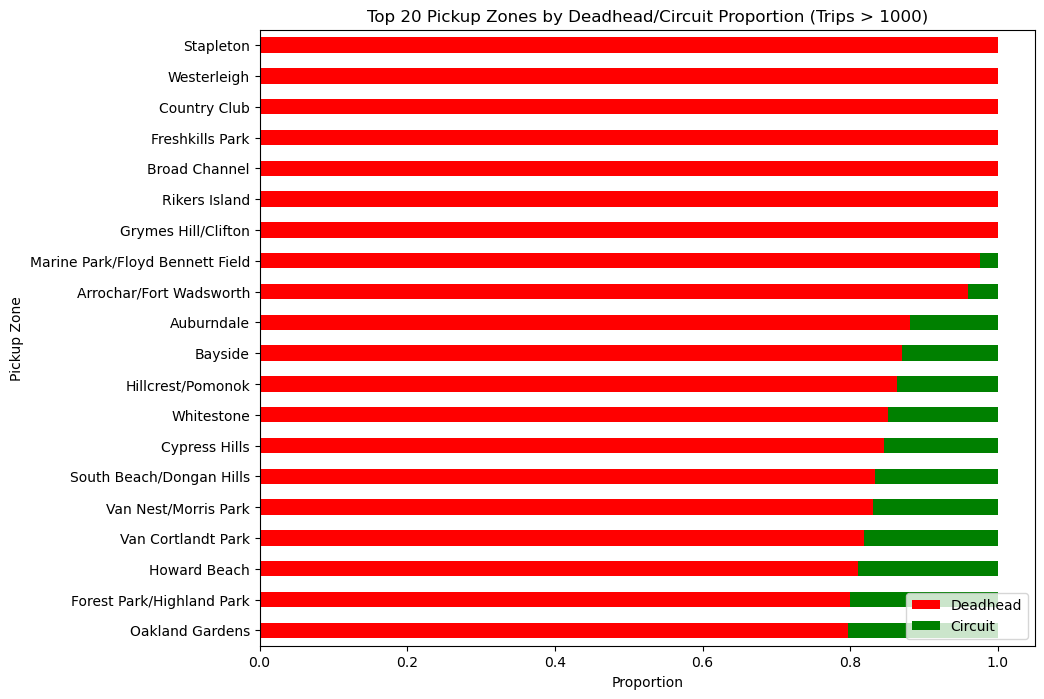

Trip counts for top 20 zones:
pickup_zone
Stapleton                            4
Westerleigh                          2
Country Club                         3
Freshkills Park                      2
Broad Channel                        3
Rikers Island                        2
Grymes Hill/Clifton                  3
Marine Park/Floyd Bennett Field     82
Arrochar/Fort Wadsworth             75
Auburndale                          59
Bayside                             54
Hillcrest/Pomonok                  168
Whitestone                          47
Cypress Hills                      202
South Beach/Dongan Hills            24
Van Nest/Morris Park               249
Van Cortlandt Park                  11
Howard Beach                       254
Forest Park/Highland Park           25
Oakland Gardens                     59
Name: total_trips, dtype: int64


In [ ]:
# Set minimum threshold for total trips to avoid bias from low-sample zones
#min_trips = 1000  # Adjust this number as needed

# Filter zones with total trips above the threshold
# proportions_filtered = proportions[proportions['total_trips'] > min_trips]
proportions_filtered = proportions[proportions['total_trips'] > 0]

# Sort by Deadhead proportion ascending or descending (you had ascending in your snippet)
proportions_sorted = proportions_filtered.sort_values(by='Deadhead', ascending=False)

# Select top 20
top_20 = proportions_sorted.head(20)

# Plot stacked bar chart for proportions
plt.figure(figsize=(10, 8))
top_20[['Deadhead', 'Circuit']].plot(
    kind='barh',
    stacked=True,
    color=['red', 'green'],
    figsize=(10, 8),
    legend=True
)

plt.xlabel('Proportion')
plt.ylabel('Pickup Zone')
plt.title('Top 20 Pickup Zones by Deadhead/Circuit Proportion (Trips > {})'.format(min_trips))
plt.gca().invert_yaxis()  # Highest proportion on top
plt.legend(loc='lower right')

# Show plot
plt.show()

# Also print the number of trips for the top 20 zones
print("Trip counts for top 20 zones:")
print(top_20['total_trips'])


<Figure size 1000x800 with 0 Axes>

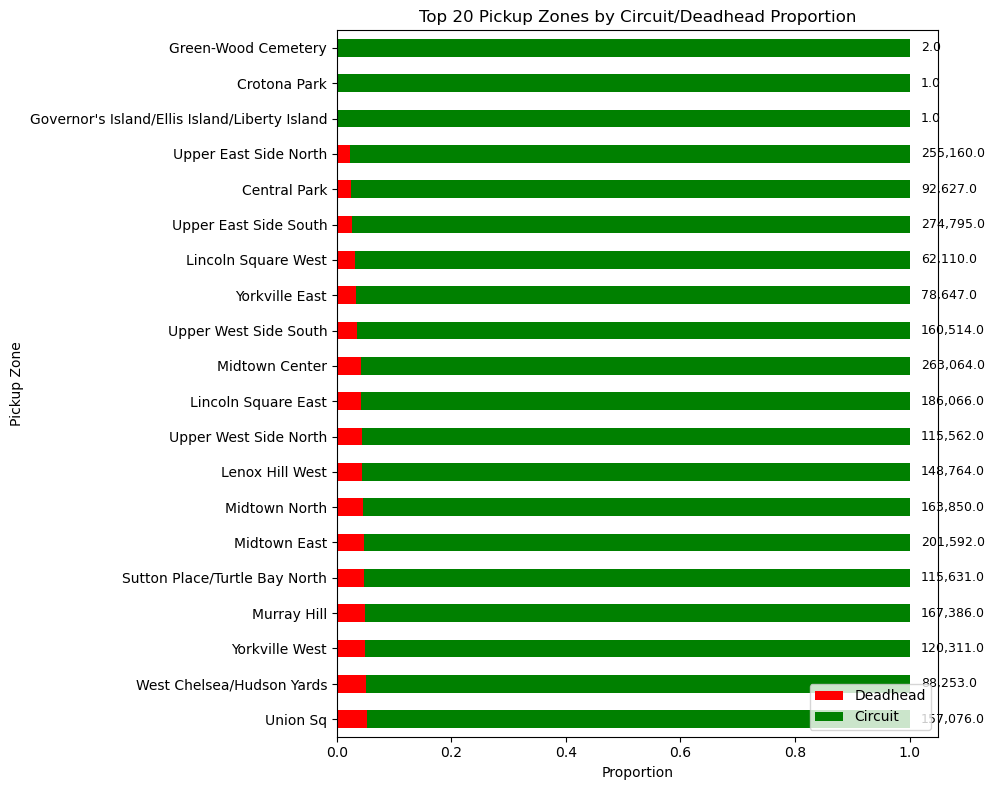

In [ ]:
# Assuming 'total_trips' column already exists in proportions (sum of counts per zone)
# If not, add it like this:
# proportions['total_trips'] = counts.sum(axis=1)

# Sort by Deadhead proportion ascending
proportions_sorted = proportions.sort_values(by='Deadhead', ascending=True)

# Select top 20
top_20 = proportions_sorted.head(20)

plt.figure(figsize=(10, 8))

# Plot stacked barh
ax = top_20[['Deadhead', 'Circuit']].plot(
    kind='barh',
    stacked=True,
    color=['red', 'green'],
    figsize=(10, 8),
    legend=True
)

plt.xlabel('Proportion')
plt.ylabel('Pickup Zone')
plt.title('Top 20 Pickup Zones by Circuit/Deadhead Proportion')
plt.gca().invert_yaxis()  # Highest on top
plt.legend(loc='lower right')

# Add trip counts as text labels to the right of bars
for i, (idx, row) in enumerate(top_20.iterrows()):
    trip_count = row['total_trips']
    ax.text(
        1.02,  # slightly past the 100% mark on x-axis
        i,     # vertical position aligned with bar index
        f'{trip_count:,}',  # formatted with commas
        va='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

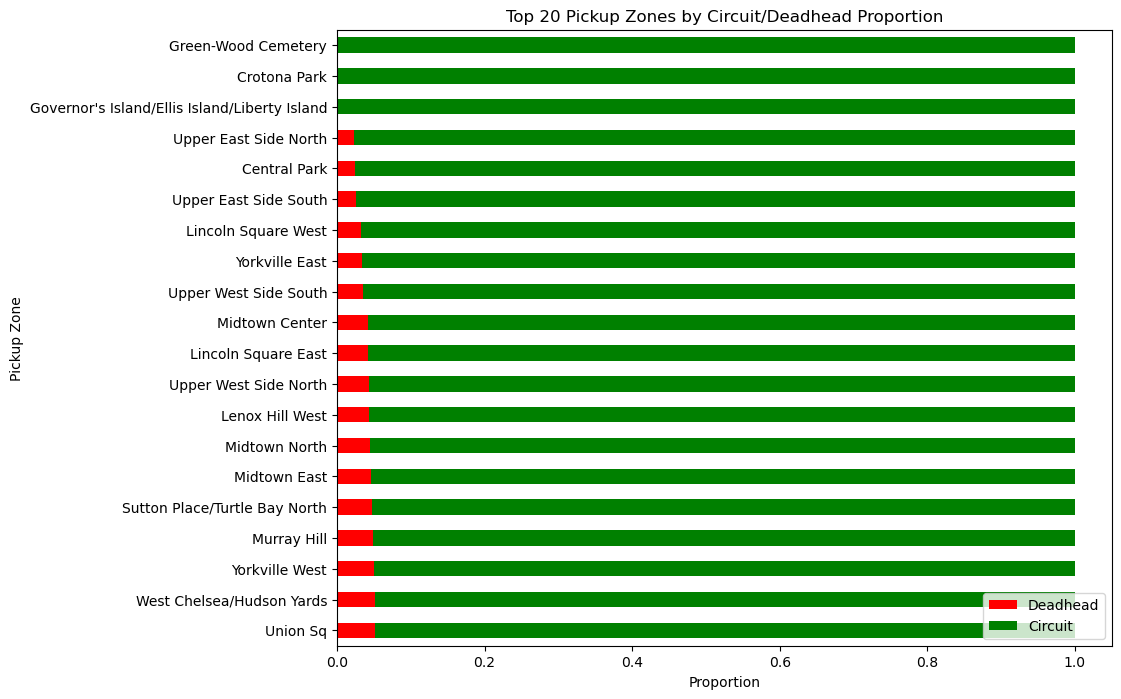

In [ ]:
# Sort by Deadhead proportion descending
proportions_sorted = proportions.sort_values(by='Deadhead', ascending=True)

# Select top 20
top_20 = proportions_sorted.head(20)

plt.figure(figsize=(10, 8))
top_20[['Deadhead', 'Circuit']].plot(
    kind='barh',
    stacked=True,
    color=['red', 'green'],
    figsize=(10, 8),
    legend=True
)
plt.xlabel('Proportion')
plt.ylabel('Pickup Zone')
plt.title('Top 20 Pickup Zones by Circuit/Deadhead Proportion')
plt.gca().invert_yaxis()  # So the highest is on top
plt.legend(loc='lower right')
plt.show()

# Need to adjust it to show trip counts > certain threshold (might be biased samples for certain ones)

### ShapeFile

In [ ]:
import geopandas as gpd

In [ ]:
shapefile_path = "/Users/elliekavanagh/Downloads/taxi_zones/taxi_zones.shp"
zones_gdf = gpd.read_file(shapefile_path)

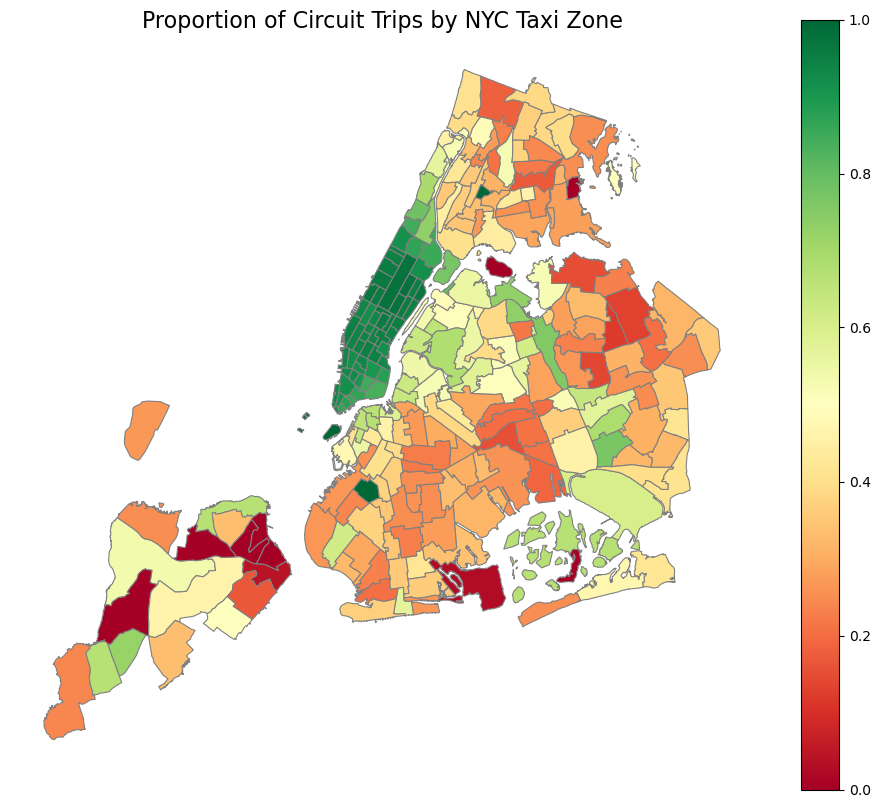

In [ ]:
map = zones_gdf.merge(proportions_sorted, how='left', left_on='zone', right_on='pickup_zone')

# Plot CIRCUIT rate map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
map.plot(column='Circuit', cmap='RdYlGn', linewidth=0.8, edgecolor='gray', legend=True, ax=ax)
ax.set_title("Proportion of Circuit Trips by NYC Taxi Zone", fontsize=16)
ax.axis('off')
plt.show()

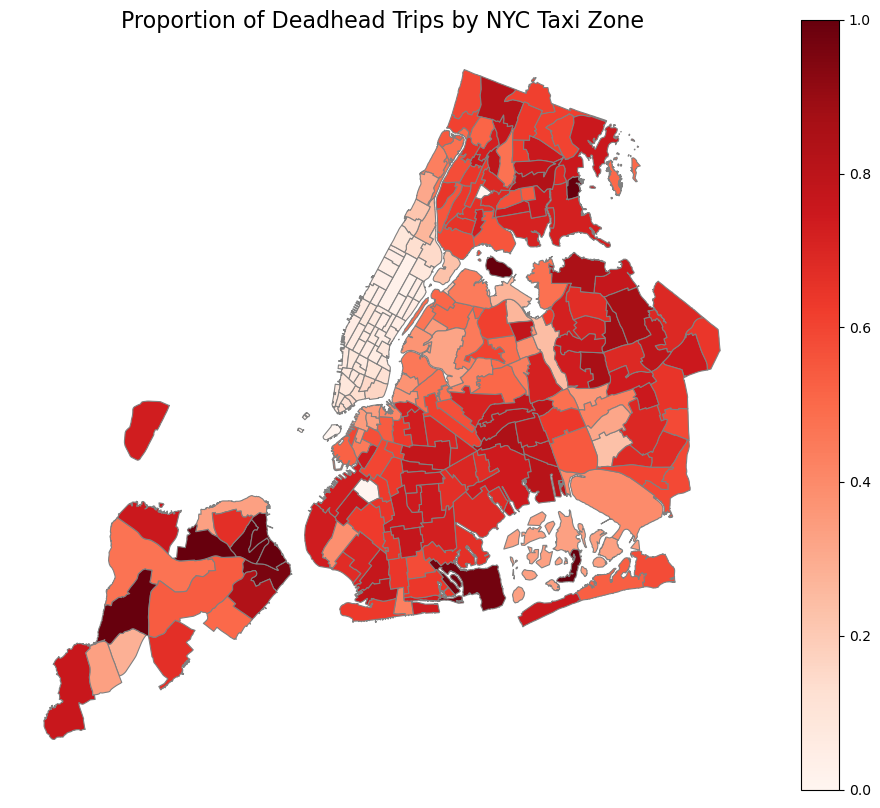

In [ ]:
# Plot DEADHEAD rate map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
map.plot(column='Deadhead', cmap='Reds', linewidth=0.8, edgecolor='gray', legend=True, ax=ax)
ax.set_title("Proportion of Deadhead Trips by NYC Taxi Zone", fontsize=16)
ax.axis('off')
plt.show()